# **Lab 8 - Explainability with ShaRP**

# Explaining rankings and classification using the ShaRP library

## Explainability

Explainability is the name given to the subfield of AI concerned with understanding _how AI models work_ and _why they make the decision they do_. Note that there are many related terms to explainability like interpretability, understandability, and comprehensbility that are useful for distinguishing nuance in a lab setting --- but ultimately, they all refer to the _human understanding of an AI system_. The overarching goal in explainability is to help us better understand an algorithmic system.

## The `ShaRP` toolkit

ShaRP (Shapley Values for Rankings and Preferences) is a framework that explains the contributions of features to different aspects of a ranked outcome, and is based on Shapley values. For more information about the method, see the [full paper](https://arxiv.org/abs/2401.16744), and for more information about the toolkit see the [documentation](https://dataresponsibly.github.io/ShaRP/).

Importantly, the ShaRP toolkit is a flexible, general framework: it can be used to explain models in many different settings including classification and ranking. We will use it for both in this lab.

#1. Import Statements

First we install `ShaRP` and the necessary packages for this lab

In [2]:
%%capture
#@markdown

# Folktables
!pip install folktables
!git clone https://github.com/lurosenb/superquail
# ShaRP
!pip install git+https://github.com/DataResponsibly/ShaRP.git
# SHAP
!pip install shap

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker

from sklearn.linear_model import LogisticRegression

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sharp import ShaRP
from sharp.qoi import TopKQoI,FlipQoI,DiffQoI
from sharp.utils import scores_to_ordering

import shap

/Users/leoyaoair23/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#2. Load Data

Next, we will load the ACSIncome dataset from the Folktables benchmark --- this is the same dataset used in Lab 2 and 3.  Folktables is based from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as-is for the following analyses.

## Data profiling

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | (Sensitive Attribute) White=1, Black=2, Other races are between 3 and 9 |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

Unlike in previous labs, we will only be working with three features: age, education level, and hours worked per week. That is because the tools we will see today work best with either continuous or ordinal variables.

In [4]:
full_df_raw_f, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome")
full_df_raw = full_df_raw_f.sample(n=150, random_state=100)
full_df_raw = full_df_raw.reset_index()

#@markdown Change data types of categorical features
numerical_cols = ['AGEP','WKHP']
ordinal_cols = ['SCHL']

full_df = full_df_raw.filter(items=numerical_cols+ordinal_cols)

X = full_df.to_numpy()

full_df.info()
full_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    150 non-null    float64
 1   WKHP    150 non-null    float64
 2   SCHL    150 non-null    float64
dtypes: float64(3)
memory usage: 3.6 KB


,AGEP,WKHP,SCHL
0,68.0,40.0,16.0
1,28.0,40.0,16.0
2,54.0,40.0,21.0
3,45.0,28.0,22.0
4,56.0,40.0,21.0


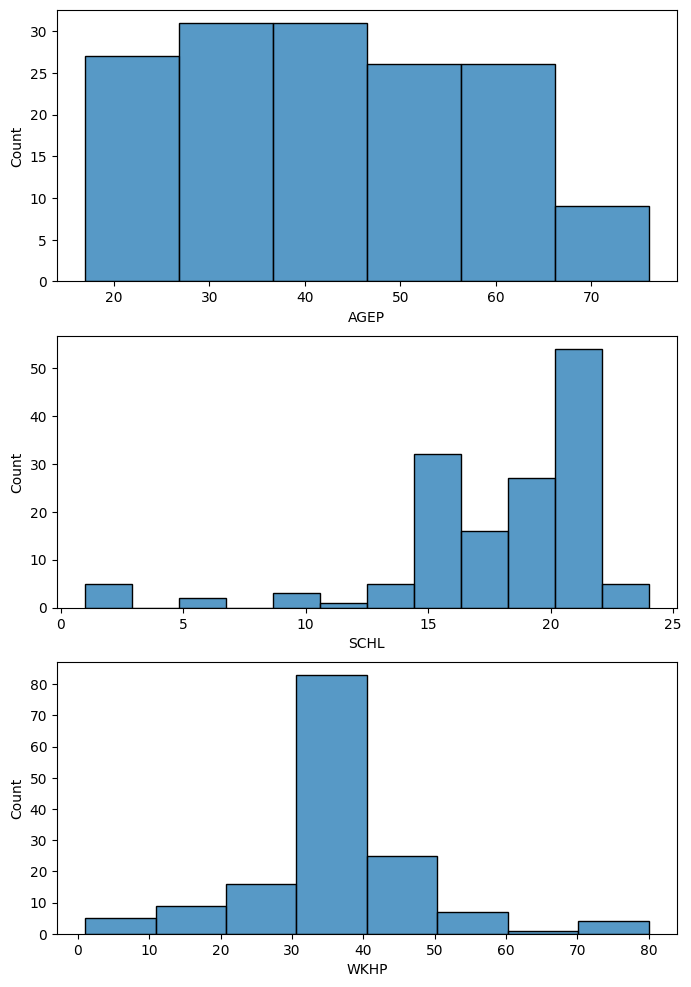

In [5]:
#@markdown Plot distribution of columns

fig, ax = plt.subplots(3,1,figsize=(8,12))

ax[0] = sns.histplot(data=full_df, x="AGEP", binwidth=10, ax=ax[0])
ax[1] = sns.histplot(data=full_df, x="SCHL", binwidth=2, ax=ax[1])
ax[2] = sns.histplot(data=full_df, x="WKHP", binwidth=10, ax=ax[2])

plt.show()

**Sample size:** Note that for this lab, we are using a random sample of only 150 individuals (this is for convenience and runtime).

## Classification

In many of our labs, we have been interrogating models in a _classification_ setting. To review, classification is a supervised machine learning method where the model tries to predict the correct label of a given input data. Like in Labs 2 and 3, we will use the selected features to predict whether or not a person makes more or less than $50,000 per year.

We begin by training a classifier using our 3 features (`AGEP, SCHL, WKHP`):

In [6]:
# We need to create a variable containing our target
y = full_df_raw['PINCP'].to_numpy()
y.shape

(150,)

In [7]:
# Normalized
scaler = StandardScaler()
X_s = scaler.fit_transform(X) # Apply a standard scaler
clf = LogisticRegression(random_state=0,solver='liblinear').fit(X_s, y)

/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_50737/3990927298.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["AGEP",'WKHP',"SCHL"])


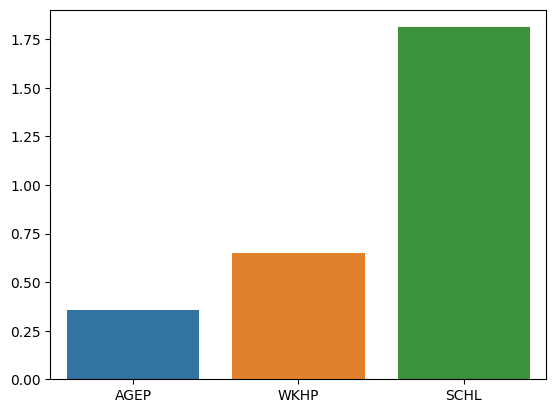

In [8]:
#@markdown We can look at the feature importances according to our model

ax = sns.barplot(clf.coef_)
ax.set_xticklabels(["AGEP",'WKHP',"SCHL"])
plt.show()


### SHAP

As a review of what was completed in previous labs, let's inspect the [SHAP](https://shap.readthedocs.io/en/latest/) waterfall for the point with the highest score.

In [9]:
y_pred_proba = clf.predict_proba(X_s)[:,1] # Save the predicted probabilities
itop = np.argmax(y_pred_proba)
ibottom = np.argmin(y_pred_proba)

#explainer = shap.KernelExplainer(clf.predict_proba, X)
explainer = shap.KernelExplainer(clf.predict, X_s)

shap_values = explainer(X_s)

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 150/150 [00:01<00:00, 89.68it/s]


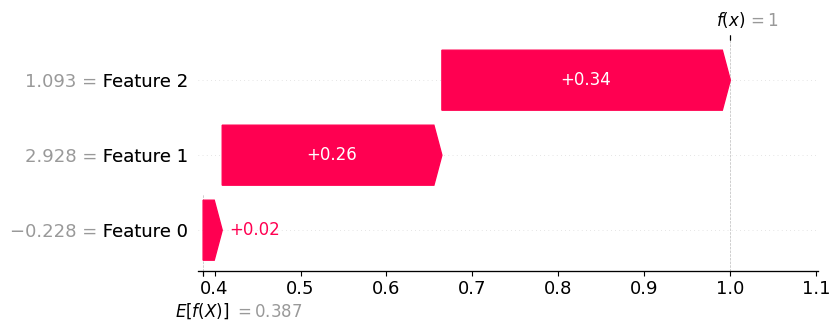

In [10]:
# Create a waterfall plot of the top scored item

#shap.plots.waterfall(shap_values[itop][:,1])
shap.plots.waterfall(shap_values[itop])


Note that features are given in order and 0-indexed, so Feature 0 = `AGEP`, Feature 1 = `WKHP`, and Feature 2 = `SCHL`.

### ShaRP
Now we will create a ShaRP object and store it in the variable `sharp_explainer`. The object has the following important parameters:

*   `qoi`: The _Quantity of Interest_ that is used to evaluate feature contributions. In the [full paper](https://arxiv.org/pdf/2401.16744.pdf) you can find explanations of different QoIs.
*   `target_function`: A function that creates the scores for each item (for example, the scoring function defined by the bank)
*   `measure`: The method for generating feature contributions and importances; choices include `unary`, `marginal` and `banzhaff`
*   `sample_size`: You can specify the number of datapoints that are used to calculate feature contributions. This results in approximate solutions and can be useful when you have large datasets, because computation is faster for lower `sample_size' values.



In [11]:
sharp_explainer = ShaRP(
    qoi="diff",
    target_function=clf.predict,
    measure="shapley",
    sample_size=None,
    replace=False,
    random_state=42,
)
sharp_explainer.fit(X_s)

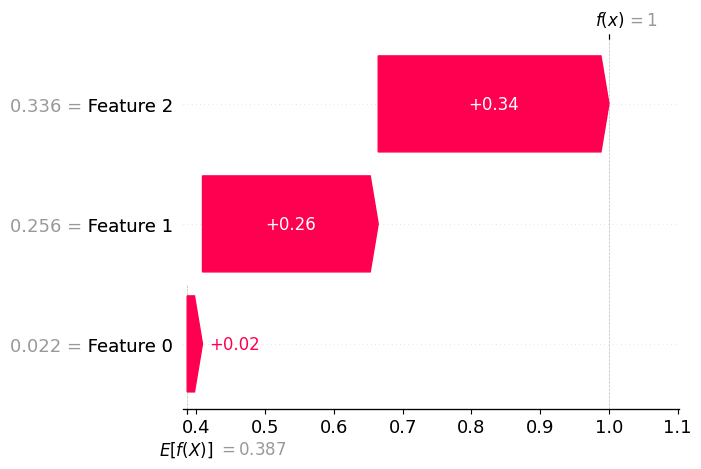

In [12]:
individual_scores = sharp_explainer.individual(int(itop), X_s)
sharp_explainer.plot.waterfall(individual_scores, mean_target_value=clf.predict(X_s).mean())

plt.show()

Again note that features are given in order and 0-indexed, so Feature 0 = `AGEP`, Feature 1 = `WKHP`, and Feature 2 = `SCHL`.

# **TODO 1:** Compare and contrast the plots created by SHAP and ShaRP.
We can see that both plots have the same E, but the scores for all three features are higher in SHAP than ShaRP.

## Ranking

To understand a significant power of ShaRP, we will explore **ranking**. Ranking is concerned with returning a permutation of the items (e.g.,  applicants for jobs or loans) in dataset D. The order in which items are returned typically corresponds to their quality or relevance, with "better" items (e.g., job applicants with more years of experience or loan applicants with a higher FICO score) appearing closer to the top of the ranked list. Ranking is often used in support of decision-making, with items appearing at higher ranks receiving more attention and having a higher likelihood of being treated positively (e.g., be invited for job interviews or being granted a loan).  

### Ranking high-earning persons

Suppose that a bank wants to rank individuals in this dataset who are are potentially high-earning to send them information about a loan opportunity. A team at the bank comes up with the following *scoring function*:

$$ Score = 20\% ~\cdot ~AGEP ~+ ~30\%~\cdot~WKHP ~+ ~50\%~\cdot~SCHL   $$

A score is computed for each individual in the bank's customer database, individuals are ranked on their score from higher to lower, and flyers to apply for the loan are sent to the best-ranked (i.e., highers-scoring) 50 individuals (the top-50).

**Side note:** when building a ranker like this, it is often important to _standardize_ features. For example, if one of these features were `income last year` and the mode value was \$50,000, it would orders of magnitude larger than the other features. Consider the ranker that was $Score = 10\% ~\cdot$ `income last year` $+ 90\% ~\cdot$ `SCHL`, all of $Score$ would be from `income last year`. We do this in the code block below.

In [13]:
#@markdown Define the scoring function and calculate the scores of all individuals

def score_function(X):
    # AGEP, WKHP, SCHL
    return 0.2 * X[:, 0] + 0.3 * X[:, 1] + 0.5 * X[:, 2]

# Save the dataframe into a numpy array called X
X_r = full_df.to_numpy()

# Standardize X
scaler = MinMaxScaler()
X = scaler.fit_transform(X_r)

y = score_function(X)

In [14]:
sharp_ranking = ShaRP(
    qoi="rank",
    target_function=score_function,
    measure="shapley",
    sample_size=None,
    replace=False,
    random_state=42,
)

sharp_ranking.fit(X)

Let's look at the ranks of all 150 individuals in the dataset. We can use the function `scores_to_ordering` to output a list containing the rank of each item in the original dataset. For example, consider the following toy dataset (note `y` is the score):

| index | name     | y |
|-------|----------|---|
| 0     | Person A | 0 |
| 1     | Person B | 1 |
| 2     | Person C | 3 |



If `scores_to_ordering(y)` outputs `[3,2,1]`, then `Person A` is ranked 3rd, `Person B` is ranked 2nd, and `Person C` is ranked 1st.

In [15]:
order = scores_to_ordering(y)
order

array([ 61, 117,  24,  56,  19,  20, 141,   9,  78,   1, 143, 121,  97,
       149,  27,   4,  43,  12, 110, 120,  55, 145,  76, 107,  26, 108,
        50,  22,  89, 116,  21,   6,  98, 128,  99, 124,  18, 105,  32,
       109,  85,  74,  88, 139,  14, 122,  62,   8,  93, 133, 132,  11,
       147,  13,  86,  37,   2, 131,  38,  94, 101,  63, 142,  31,  58,
        68,  16,   7,  82, 129,  87,  53,  10, 104,  15, 134,  69,  41,
        57,  70,  34,  51,  79, 112,  67, 127,  47, 106,  91, 150,  72,
        60, 130, 126,  84,  40, 146,  44,  35, 125, 119,  52,  80,  54,
        46,  64,  96,  29,  77,  17,  95, 115,  81, 123,  48, 140, 113,
        39,  45,  71, 144, 136, 148,  42, 137,   5, 138, 100,  65, 135,
        75,  59,  83, 103,  66,  90,  33, 111,  23,  49,  30,  28, 118,
        36,  73,   3, 114,  92, 102,  25])

In [16]:
#@markdown Look at the top ranked individual

ifirst = np.where(order == 1)[0]
i50th = np.where(order == 49)[0]
ilast = np.where(order == 149)[0]
print("First\n", full_df.loc[ifirst])
print("---------------------")
print("50th\n", full_df.loc[i50th])
print("---------------------")
print("Last\n", full_df.loc[ilast])

First
    AGEP  WKHP  SCHL
9  40.0  75.0  23.0
---------------------
50th
      AGEP  WKHP  SCHL
139  52.0  60.0  16.0
---------------------
Last
     AGEP  WKHP  SCHL
13  61.0  30.0   1.0


In [17]:
#@markdown Inspect the aggregate feature contributions
# aggregate_contributions = sharp_ranking.all(X).mean(axis=0)
aggregate_contributions = np.absolute(sharp_ranking.all(X)).mean(axis=0)

/var/folders/8p/pfvm32bd07q6ccc1n2qmv92w0000gn/T/ipykernel_50737/3367541334.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["AGEP",'WKHP',"SCHL"])


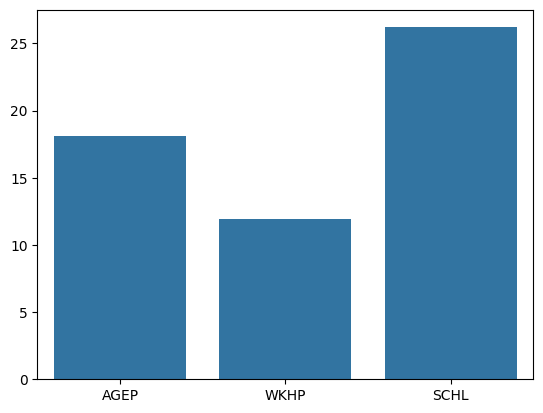

In [18]:
ax = sns.barplot(list(aggregate_contributions))
ax.set_xticklabels(["AGEP",'WKHP',"SCHL"])
plt.show()


According to ShaRP, the most important feature (i.e. the feature with the largest _magnitude_) for determining a given ranking (in the aggregate) is `SCHL`, followed by `WKHP`, and lastly `AGE`. Note that while the order is different, the magnitudes are very different from the original ranker (i.e. `SCHL` made up 50% of the score.) This will be explained a bit later.

With ShaRP we can also look at the feature contirbutions for any individual. These plots answer the question, "which features (and to what extent) led to an individual receiving the rank they did?"

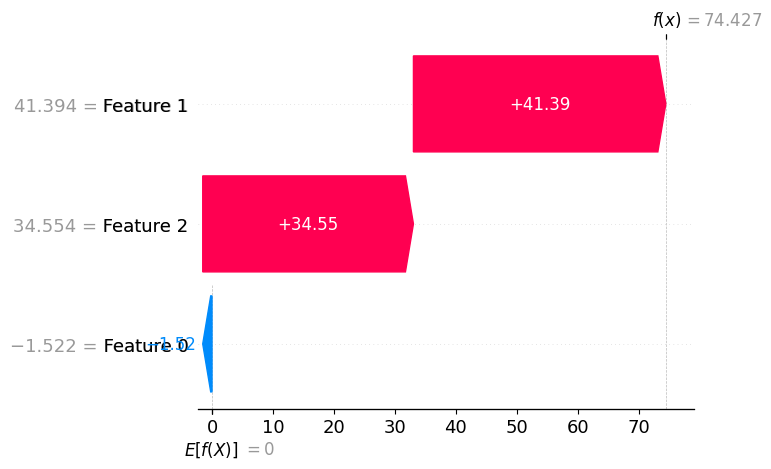

In [19]:
#@markdown Inspect the individual feature contributions

individual_scores = sharp_ranking.individual(int(ifirst[0]), X)
sharp_ranking.plot.waterfall(individual_scores)

plt.show()

Note that features are labeled from left to right as they are found in the dataset, so: `0 = AGEP, 1 = WKHP, 2 = SCHL`. Therefore, according to the plot, their high ranking can be attributed to their hours worked per week, followed by their school.

At first, this can be a slightly unintuitive. Why would the feature importances for the Waterfall plot be different from the weights of the features in the ranker? In a sense, ShaRP tells us the importance of each feature _with respect to feature values found in the dataset_. For example, we know from inspecting the dataset, that a vast majority of individuals work 40 hours per week --- so even though `WKHP` makes up 30% of the score, it is basically the same for everyone. But for this individual, it is actually _higher_, making it a signficiant reason why this individual was ranked higher.


Let's reinspect that individual to make sure this makes sense:



In [20]:
print(full_df.loc[ifirst])

   AGEP  WKHP  SCHL
9  40.0  75.0  23.0


# **TODO 2:** Make a waterfall plot for the 50th and lasted rank individual. How do they differ from the plot for the first ranked individual? Do the plot seems reasonable?

All three plots seem very different from each other. The first have two positive featuers and one only slightly negative. The 50th also have two positive but the negtaive is more negative. The last have two negatives and one positive. 

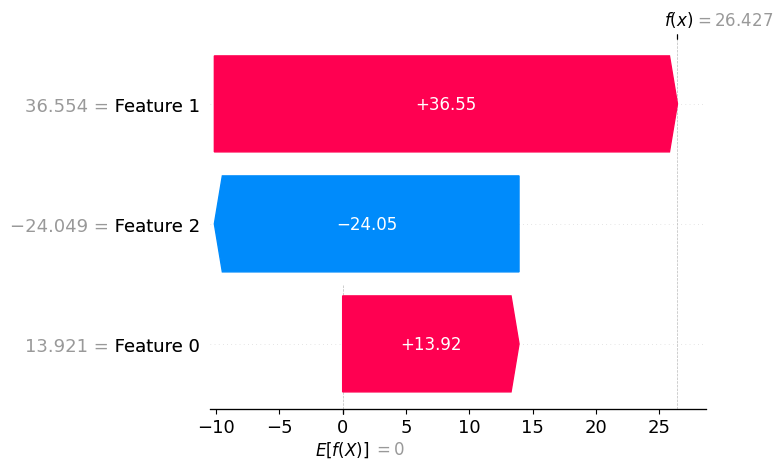

In [21]:
# Code goes here
individual_scores = sharp_ranking.individual(int(i50th[0]), X)
sharp_ranking.plot.waterfall(individual_scores)

plt.show()

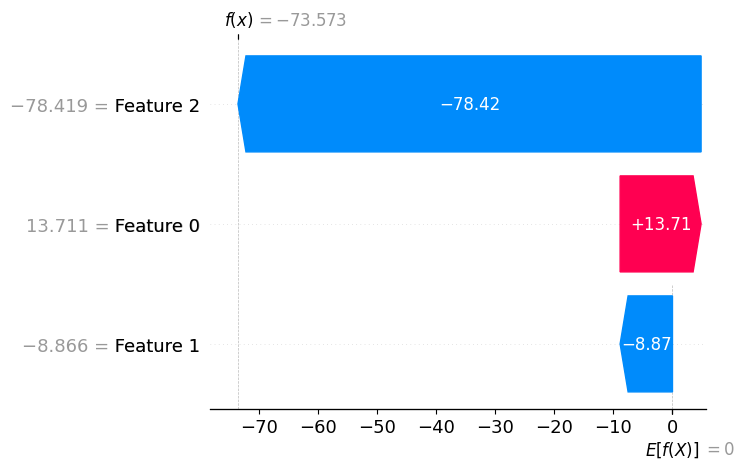

In [22]:
# Code goes here
individual_scores = sharp_ranking.individual(int(ilast[0]), X)
sharp_ranking.plot.waterfall(individual_scores)

plt.show()

Another interesting analysis we can do is see how feature contributions differ by _ranking strata_ --- it is likely that, depending on where an item sits in the ranking, certain feature influences are more likely. In the following code, we break our data up into 5 stratas each consisting of 20% of the data, and inspect feature importances.

In [ ]:
df = pd.DataFrame(sharp_ranking.all(X))

buckets = 5
rows = X.shape[0]
df['My Rank'] = scores_to_ordering(y)
df['Rank Bucket'] = ["0-\n20%" if math.floor((rank - 1) / (rows / buckets)) == 0 else str(math.floor((rank - 1) / (rows / buckets)) * 20) + "-\n" + str(math.floor(((rank - 1) / (rows / buckets)) + 1) * 20) + "%" for rank in df['My Rank']]
df.sort_values(by=['Rank Bucket'],inplace=True)
yaxis_order = list(df.sort_values(by=['Rank Bucket'])['Rank Bucket'].unique())

df = (
    df
    .drop(columns=["My Rank"])
    .melt(id_vars=["Rank Bucket"])
    .rename(columns={"variable": "Feature", "value": "Contribution"})
)

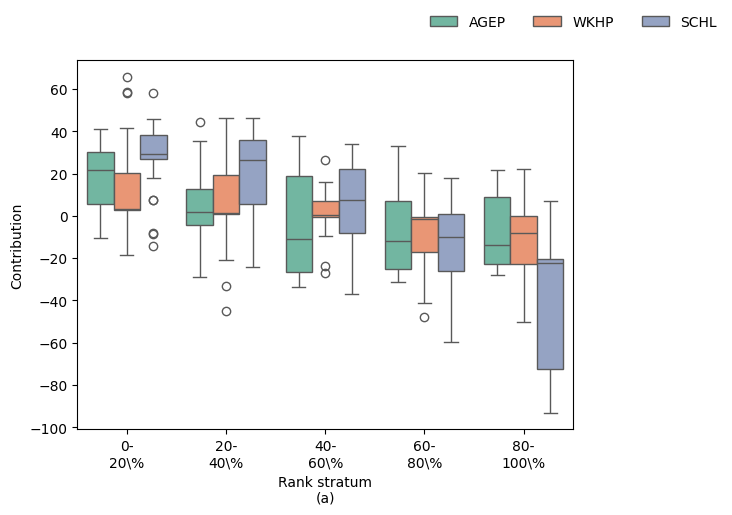

In [ ]:
plot_df = df.copy()

plot_df["Rank Bucket"] = plot_df["Rank Bucket"].str.replace("%", "\%").str.replace("<", "$<$")

graph = sns.boxplot(x = plot_df['Rank Bucket'], y = plot_df['Contribution'], hue = plot_df['Feature'], palette = "Set2")
sns.move_legend(
    graph, "lower center", bbox_to_anchor=(1, 1.05), ncol=4, title=None, frameon=False, labels=["AGEP",'WKHP',"SCHL"]
)
plt.setp(graph.patches, linewidth=1)
graph.set_xlabel("Rank stratum\n(a)")

plt.show()

Interestingly, hours worked per week is only really important for explaining high-ranked and low-ranked items. Items ranked in "the middle of the pack" are best explained by their values of `AGEP` and `SCHL`.

# **TODO 3:** Compare and contrast the "feature importances" we saw in this lab: (1) the regression coefficients of the trained classifier in Part 1 (2) the ranker weights set by the experts at the bank, and (3) the aggregate feature importance of the ranker according to ShaRP.

The regression coefficients for all three features are all positive. The aggregate feature importances of the ranker are also all positive, but the order is different. The ranker weights have both positive and negative values.